In [1]:
import torch
import torch.nn as nn

# 填充和步幅
出了输入和卷积核的大小会影响输出的大小之外, 填充和幅度也会影响输出的大小, 比如对于一个 $240 \times 240$像素的图像, 经过 $10$ 层 $5 \times 5$ 的卷积之后, 将减少到 $200 \times 200$像素, 这样一来, 原始图像的边界丢失了许多有用的信息, 此时可以使用填充来解决这一个问题 ; 同时也希望可以降低图像的宽度和高度, 所以可以使用步幅控制

**Q1: 为什么这里说不使用填充会导致边缘像素的丢失?**
答: 因为对于边缘位置卷积核只能覆盖一次, 但是中间的位置卷积核可以覆盖多次, 所以可能导致在多层卷积之后, 边缘信息几乎丢失

## 填充
为了减少边缘丢失的像素, 可以使用**填充**的方法: 在输入图像的边界填充元素(比如可以填充 0), 如图可以这样填充元素: 
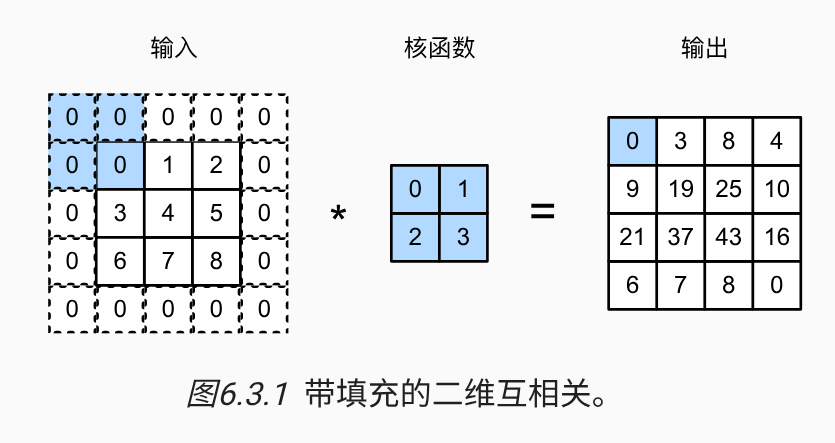
假设如果添加 $p_h$ 行填充(比如上图中 $p_h = 2$), 那么输出形状为: 
$$
(n_k - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)
$$
也就是高度和宽度都会增加 $p_h$ 和 $p_w$

一些情况下可以设置 $p_h = k_h - 1, p_w = k_w - 1$ 从而保证输入和输出具有相同的高度和宽度, 这样可以在构建网络的时候更加容易地预测每一个图层的输出形状, 假设 $k_h$ 为奇数, 那么在告诉两侧填充 $\frac {p_h}{2}$, 如果 $k_h$ 为偶数, 那么可以在一侧填充 $\frac{p_h + 1}{2}$, 另一侧填充 $\frac{p_h - 1}{2}$

通常卷积神经中卷积核的高度和宽度为奇数, 这样可以保证空间维度的同时在顶部和底部填充相同数量的行, 在左侧和右侧填充相同数量的行, 同时使用奇数大小的卷积核的优点如下:
1. 卷积核的大小是奇数；
2. 所有边的填充行数和列数相同；
3. 输出与输入具有相同高度和宽度 则可以得出：输出$Y[i,j]$是通过以输入$X[i, j]$为中心，与卷积核进行互相关计算得到的。

In [4]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1, X.shape[0], X.shape[1])) # (1,1) -> 批量,通道数
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:]) # 忽略批量等维度
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1) # 注意这里 p_h = 2*padding
X = torch.rand((8, 8))
Y = comp_conv2d(conv2d, X)
Y.shape

torch.Size([8, 8])

In [6]:
# 同时可以分别指定高度和宽度的填充, 注意到 kernel_size = 2*padding + 1 的情况下保证
# 最终得到的图像大小不变
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
Y = comp_conv2d(conv2d, X)
Y.shape

torch.Size([8, 8])

## 步幅
步幅表示卷积核每一次移动的举例, 同时也分为水平方向上和垂直方向上的步幅, 利用步幅可以有效减少输出图像的大小, 比如如下是带有步幅的卷积运算:
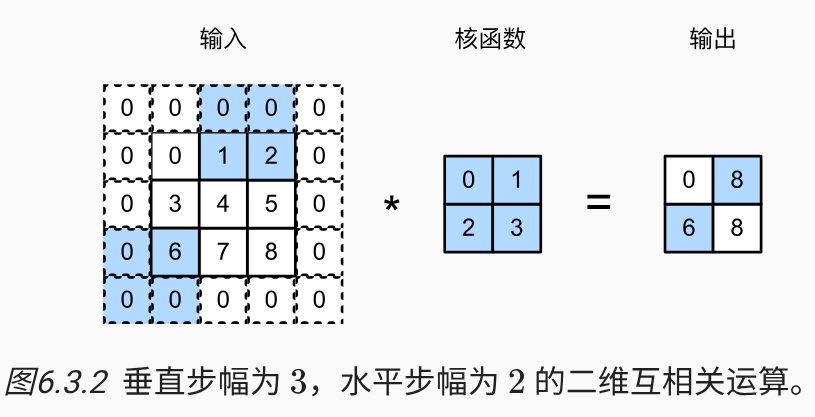
假设垂直步幅为 $s_h$, 水平步幅为 $s_w$, 那么输出形状为:
$$
\lfloor (n_h - k_h + p_h + s_h) / s_h \rfloor \times \lfloor (n_w - k_w + p_w + s_w) / s_w \rfloor
$$
同时如果设置了 $p_h = k_h - 1, p_w = k_w - 1$, 那么输出形状可以简化为:
$$
\left\lfloor \frac{n_h + s_h - 1}{s_h} \right\rfloor \times \left\lfloor \frac{n_w + s_w - 1}{s_w} \right\rfloor
$$
同时如果输入的高度和宽度可以被水平步幅或者垂直步幅整除, 那么输出形状为:
$$
\frac {n_h}{s_h} \times \frac{n_w}{s_w} 
$$

In [8]:
# 演示步幅运算
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [10]:
# 不规则步幅
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape
# h = (8 - 3 + 0*2 + 3)/3 = 8/3 = 2
# w = (8 - 5 + 1*2 + 4)/4 = 9/4 = 2

torch.Size([2, 2])

## 总结
- 填充可以增加输出的高度和宽度, 可以使得输出和输入具有相同的高度和宽度
- 步幅可以减少输出的高度和宽度, 例如输出的高和宽仅为输入的高和宽的 $\frac{1}{n}$ 
- 填充和步幅可以用于调整数据的维度
其实两者之间还是存在矛盾的关系, 一个增加图像宽度从而增加边缘像素信息, 另外一个减少图像尺寸从而减少信息